In [1]:
import warnings
from pathlib import Path
from dataclasses import dataclass
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download


## Constants

In [2]:
FIGURES_DIR = Path("figures")
HF_REPO_ID = "argmaxinc/interspeech-artifacts"
WANDB_DATA_DIR = Path("wandb_data")
DATASET_INFO_DIR = Path("dataset_statistics")

PRIMARY_BENCHMARK_DATASETS = [
    "ami-test-ihm",
    "ami-test-sdm",
    "dihard-3-full-None",
    "american-life-test-None",
    "callhome-part2-None",
    "icsi-meetings-test-None",
    "msdwild-validation-None",
    "aishell-4-test-None",
    "earnings21-test-None",
    "voxconverse-test-None",
    "ali-meetings-test-None",
    "ava-avd-test-None",
    "ego4d-validation-None",
]

ABLATION_DATASETS = [
    "voxconverse-dev-None",
    "ami-validation-ihm",
    "ami-validation-sdm",
    "dihard-3-core-None",
    "american-life-validation-None"
]

## Helper Functions

### Dataset Statistics Helpers

In [3]:
@dataclass
class DatasetInfo:
    owner: str
    dataset_name: str
    split: str
    subset: str | None = None

def parse_dataset_filename(filepath: Path) -> DatasetInfo:
    parts = filepath.name.split("_")
    return DatasetInfo(
        owner=parts[0],
        dataset_name=parts[2],
        split=parts[4],
        subset=parts[3]
    )

def load_all_dataset_statistics(files: list[Path]) -> pd.DataFrame:
    """
    Loads all the dataset statistics from the given files.
    """
    dfs = []
    for f in files:
        info = parse_dataset_filename(f)
        df = pd.read_csv(f)
        orig_cols = df.columns.tolist()
        new_cols = ["dataset_id", "dataset_name", "split", "subset"]
        df["dataset_name"] = info.dataset_name
        df["split"] = info.split
        df["subset"] = info.subset
        df["dataset_id"] = f"{info.dataset_name}-{info.split}-{info.subset}"
        df = df[new_cols + orig_cols]
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True).sort_values(by=["dataset_name", "subset", "split"])


def load_dataset_statistics(is_agg: bool = True, dataset_ids: str | list[str] | None = None) -> pd.DataFrame:
    """
    Loads the dataset statistics from the dataset_statistics directory.
    If is_agg is True, the aggregated statistics are loaded, otherwise the per-sample statistics are loaded.
    If dataset_ids is provided, only the statistics for the specified dataset ids are loaded.
    Final dataframe is a concatenation of all the loaded dataframes.
    """
    dir = DATASET_INFO_DIR / ("agg_info" if is_agg else "per_sample_info")
    files = list(dir.glob("*.csv"))
    df = load_all_dataset_statistics(files)

    if dataset_ids is None:
        return df
    
    dataset_ids = dataset_ids if isinstance(dataset_ids, list) else [dataset_ids]
    return df[df["dataset_id"].isin(dataset_ids)]

### Data Manipulation Helpers

In [4]:
# Deduplicates based on run_name taking latest created_at
dedup_func = lambda df: df.sort_values(["run_name", "created_at", "run_id"], ascending=False).drop_duplicates(subset=["sample_id", "run_name"], keep="first")

# Selects columns based on a pattern e.g. "der|rate$|^Speaker"
col_selector = lambda df, pattern: df.loc[:, df.columns.str.contains(pattern)]

# Adds a name column useful for ablations
def add_name(df: pd.DataFrame, add_ordering: bool = True) -> pd.DataFrame:
    if not add_ordering:
        return df.assign(name=lambda df: df["run_name"].str.split("-").str[2].str.split("_").str[1].fillna("Reference"))
    return df.assign(
        name=lambda df: df["run_name"].str.split("-").str[2].str.split("_").str[1].fillna("Reference"),
        name_ordering=lambda df: df["name"].apply(lambda x: int(x) if x.isdigit() else 0)
    )

# Convenient way to aggregate and get DER its compoenets and Speed Factor -> Can be used for other things if using agg_mapper and assigner
def aggregation_pipeline(df: pd.DataFrame, groupby_cols: list[str], col_pattern: str | None = None, agg_mapper: dict | None = None, assigner: dict | None = None):
    cols = df.columns
    has_speed_factor = "audio_duration" in cols and "prediction_time" in cols

    if agg_mapper is None:
        agg_mapper = {
            "total": "sum",
            "confusion": "sum",
            "false alarm": "sum",
            "missed detection": "sum",
        }
        if has_speed_factor:
            agg_mapper["audio_duration"] = "sum"
            agg_mapper["prediction_time"] = "sum"
    
    if assigner is None:
        assigner = {
            "confusion_rate": lambda df: df["confusion"] / df["total"],
            "false_alarm_rate": lambda df: df["false alarm"] / df["total"],
            "missed_detection_rate": lambda df: df["missed detection"] / df["total"],
            "der": lambda df: (df["false alarm"] + df["missed detection"] + df["confusion"]) / df["total"],
        }
        if has_speed_factor:
            assigner["speed_factor"] = lambda df: df["audio_duration"] / df["prediction_time"]
    
    return (
        df
        .groupby(groupby_cols, as_index=False)
        .agg(agg_mapper)
        .assign(**assigner)
        .pipe(lambda df: df.pipe(col_selector, col_pattern if col_pattern else "|".join(df.columns.tolist())))
    )

## Loading Data

In [5]:
snapshot_download(HF_REPO_ID, allow_patterns=[f"{DATASET_INFO_DIR}/*"], local_dir=".")
snapshot_download(HF_REPO_ID, allow_patterns=[f"{WANDB_DATA_DIR}/*"], local_dir=".")

# W&B related data
df_prediction = pd.read_parquet(WANDB_DATA_DIR / "diarization_prediction_table.parquet")
df_der = pd.read_parquet(WANDB_DATA_DIR / "per_sample_der.parquet")
df_jer = pd.read_parquet(WANDB_DATA_DIR / "per_sample_jer.parquet")

# Dataset statistics related data
ds_ablation_sample = load_dataset_statistics(is_agg=False, dataset_ids=ABLATION_DATASETS)
ds_agg_info = load_dataset_statistics(is_agg=True, dataset_ids=PRIMARY_BENCHMARK_DATASETS)
ds_per_sample_info = load_dataset_statistics(is_agg=False, dataset_ids=PRIMARY_BENCHMARK_DATASETS)

Fetching 182 files: 100%|██████████| 182/182 [00:16<00:00, 11.10it/s]


## W&B Base Data for Figures

In [6]:
df = (
    df_der
    # Merge with the prediction table to get audio_duration and prediction_time
    .merge(
        df_prediction,
        on=["sample_id", "dataset_name", "run_name", "run_id", "experiment_tag", "created_at", "pipeline_name"],
        how="inner", 
        suffixes=["", "_pred"]
    )
    # Compute per sample speed factor
    .assign(
        speed_factor=lambda df: df["audio_duration"] / df["prediction_time"]
    )
    # Deduplicate based on latest created_at for an experiment run
    .pipe(dedup_func)
)

df.head()

,dataset_name,sample_id,pipeline_name,correct,missed detection,total,confusion,false alarm,der,run_name,run_id,experiment_tag,created_at,prediction_time,audio_duration,num_speakers_predicted,num_speakers_reference,speed_factor
33232,voxconverse,0,PyAnnotePipeline,1093.079906,15.347375,1117.39,8.962719,28.413625,0.047185,pyannote-voxconverse-float16,bwzrnx7u,Benchmark-SpeakerDiarization,2025-03-20 03:15:45+00:00,23.068819,1200.064,8,7,52.021042
33233,voxconverse,1,PyAnnotePipeline,1064.236719,22.663469,1110.04,23.139812,42.708469,0.079737,pyannote-voxconverse-float16,bwzrnx7u,Benchmark-SpeakerDiarization,2025-03-20 03:15:45+00:00,22.519042,1200.064,13,12,53.291077
33234,voxconverse,2,PyAnnotePipeline,403.422500,0.675625,413.09,8.991875,6.693125,0.039605,pyannote-voxconverse-float16,bwzrnx7u,Benchmark-SpeakerDiarization,2025-03-20 03:15:45+00:00,8.105422,430.720,1,3,53.139735
33235,voxconverse,3,PyAnnotePipeline,493.377656,22.936531,527.42,11.105812,36.714656,0.134157,pyannote-voxconverse-float16,bwzrnx7u,Benchmark-SpeakerDiarization,2025-03-20 03:15:45+00:00,10.374021,572.224,2,2,55.159324
33236,voxconverse,4,PyAnnotePipeline,1157.346594,50.296656,1256.04,48.396750,11.416656,0.087664,pyannote-voxconverse-float16,bwzrnx7u,Benchmark-SpeakerDiarization,2025-03-20 03:15:45+00:00,21.624620,1200.064,11,9,55.495265


## Figure 1

In [7]:
# Getting data from runs related to the primary benchmark
data = (
    df
    .query("experiment_tag == 'Benchmark-SpeakerDiarization'")
)

# Getting specific data for Figure 1 - Panel A
df_fig1 = (
    data
    .query("pipeline_name != 'CoreMLPipeline'")
    .pipe(aggregation_pipeline, groupby_cols=["pipeline_name", 'dataset_name'])
    .sort_values(["pipeline_name", "dataset_name"])
    .rename(columns={"der": "DER", "pipeline_name": "Model", "dataset_name": "Dataset", "speed_factor": "Speed Factor"})
    .replace(
        [
            'aishell-4', 'ali-meetings', 'american-life-podcast', 'ami-ihm',
            'ami-sdm', 'ava-avd', 'callhome', 'dihard-3', 'earnings21',
            'ego4d', 'icsi', 'msdwild', 'voxconverse'
        ],
        [
            'AISHELL-4','AliMeeting', 'American-Life-Podcast','AMI-IHM','AMI-SDM',
            'AVA-AVD','CallHome','DIHARD-III','Earnings-21', 'EGO4D',
            'ICSI', 'MSDWILD', 'VoxConverse'
        ]
    )
    .replace(
        [
            'AWSTranscribePipeline', 'PicovoicePipeline', 'PyAnnotePipeline',
            'PyannoteApiPipeline', 'SpeakerKitPipeline'
        ],
        [
            'AWS Transcribe','Picovoice','Pyannote',
            'Pyannote-AI','SpeakerKit'
        ]
    )
)

# Getting data for Figure 1 - Panel B
df_fig1_agg = (
    data
    .query("pipeline_name != 'CoreMLPipeline'")
    .pipe(aggregation_pipeline, groupby_cols=["pipeline_name"])
    .rename(columns={"der": "global_der"})
    [[ "pipeline_name","confusion", "false alarm", "missed detection", "total", "global_der","speed_factor"]]
    .replace(
        [
            'AWSTranscribePipeline', 'PicovoicePipeline', 'PyAnnotePipeline',
            'PyannoteApiPipeline', 'SpeakerKitPipeline'
        ],
        [
            'AWS Transcribe','Picovoice','Pyannote',
            'Pyannote-AI','SpeakerKit'
        ]
    )
    .rename(columns={"pipeline_name": "Model", "speed_factor": "Speed Factor", "global_der": "DER"})
    .assign(Dataset="Aggerate")
)

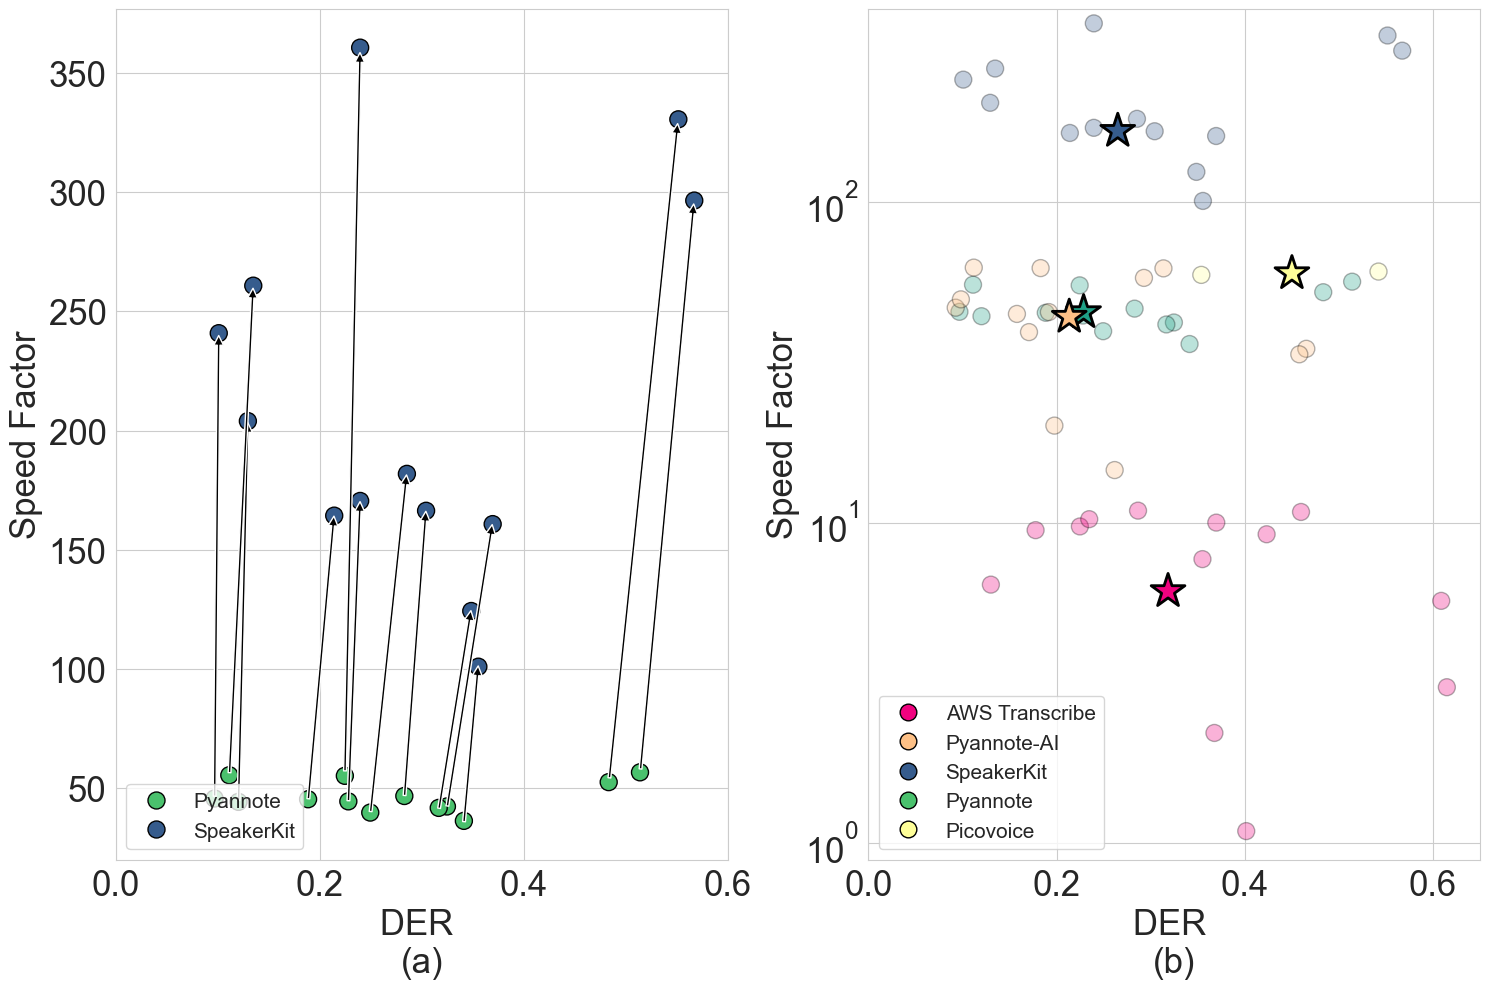

In [55]:
# Initialize plot
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
sns.set_style("whitegrid")

######################### SUBPLOT A #########################
# Pyannote vs SpeakerKit
panel_a_data = df_fig1.loc[df_fig1["Model"].isin(["SpeakerKit", "Pyannote"])].copy()
splot = sns.scatterplot(
    data=panel_a_data,
    y="Speed Factor",
    x="DER",
    hue="Model",
    palette=[ '#4ac16d','#365c8d'],
    style='Dataset',
    markers=['o','o'],
    s=150,
    edgecolor="black",
    ax=axs[0]
)

# Draw arrows from Pyannote points to SpeakerKit points
datasets = panel_a_data["Dataset"].unique()
for dataset in datasets:
    subset = panel_a_data[panel_a_data["Dataset"] == dataset].copy()
    subset_speakerkit = subset[subset["Model"] == "SpeakerKit"].copy()
    subset_pyannote = subset[subset["Model"] == "Pyannote"].copy()

    xy = (subset_speakerkit["DER"].item(), subset_speakerkit["Speed Factor"].item()+1)
    xytext = (subset_pyannote["DER"].item(),subset_pyannote["Speed Factor"].item()-1)

    axs[0].annotate(
        '',
        xy=xy,
        xytext=xytext,
        xycoords='data',
        arrowprops=dict(facecolor='black',width=2.0,headwidth=7.0,headlength=7.0,shrink=0.01)
    )


def get_axis_limits(ax, scale=.9):
    return 0.02, ax.get_ylim()[0]*scale+10

######################### FORMATTING FOR PANEL A #########################
axs[0].set_xlabel(
    "DER \n(a)", fontsize=25
)
axs[0].set_ylabel(
    "Speed Factor", fontsize=25
)
h, l = axs[0].get_legend_handles_labels()
axs[0].legend(
    handles=h[1:3],
    labels=l[1:3],
    title_fontsize=15, 
    fontsize=15,
    loc='lower left'
)
axs[0].tick_params(axis='both', which='major', labelsize=25)
axs[0].set_xlim(0, 0.6)
axs[1].set_yscale('log')
axs[1].set_ylim(0,400)


######################### SUBPLOT A #########################
# Plotting all systems with low opacaity
splot = sns.scatterplot(
    data=df_fig1,
    y="Speed Factor",
    x="DER",
    hue="Model",
    palette=['#f0027f','#ffff99',
    '#1fa187','#fdc086','#365c8d',],
    style='Dataset',
    markers=['o','o','o','o','o'],
    s=150,
    edgecolor="black",
    alpha=0.3,
    ax=axs[1]
)

h,l = axs[1].get_legend_handles_labels()

# Plotting aggregate for each system across all datasets
splot=sns.scatterplot(
    data=df_fig1_agg,
    y="Speed Factor",
    x="DER",
    hue="Model",
    palette=['#f0027f','#ffff99',
    '#1fa187','#fdc086','#365c8d'],
    style='Dataset',
    markers=['*'],
    s=650,
    edgecolor="black",
    ax=axs[1]
)

######################### FORMATTING FOR PANEL B #########################
plt.xlim(0, 0.65)

h1,l1 = axs[1].get_legend_handles_labels()
axs[1].set_xlabel("DER \n(b)", fontsize=25)
axs[1].set_ylabel("Speed Factor", fontsize=25)

markers = {'AWS Transcribe': 'o','Pyannote-AI': 'o', 
           'SpeakerKit': 'o','Pyannote':'o','Picovoice':'o'}
color_dict={'Pyannote':'#4ac16d','SpeakerKit':'#365c8d',
            'AWS Transcribe':'#f0027f', 'Picovoice':'#ffff99',
            'Pyannote-AI':'#fdc086'}
 
# Create custom legend for strides only
panelb_legend = [
    plt.Line2D(
        [0], 
        [0], 
        color=color_dict[model],
        mec='black',
        marker=marker, 
        linestyle='None',
        markersize=12, 
        label=model 
    ) 
    for model, marker in markers.items()
]

axs[1].legend(title_fontsize=15, fontsize=15,
              labels=['AWS Transcribe','Pyannote-AI',
              'SpeakerKit','Pyannote','Picovoice'],
              handles=panelb_legend,loc='lower left')
axs[1].tick_params(axis='both', which='major', labelsize=25)

plt.tight_layout()
plt.show()

In [30]:
dataset_mapper = {
    "aishell-4-test-None": "AISHELL-4",
    "ali-meetings-test-None": "Ali-Meetings",
    "american-life-test-None": "American-Life-Podcast",
    "ami-test-ihm": "AMI-IHM",
    "ami-test-sdm": "AMI-SDM",
    "ava-avd-test-None": "AVA",
    "callhome-part2-None": "Call Home",
    "dihard-3-full-None": "DIHARD-III",
    "earnings21-test-None": "Earnings-21",
    "ego4d-validation-None": "EGO4D",
    "icsi-meetings-test-None": "ICSI",
    "msdwild-validation-None": "MSD-Wild",
    "voxconverse-test-None": "Vox-converse",
}

ds_agg_info["dataset_id"].apply(lambda x: dataset_mapper.get(x)).tolist()

['AISHELL-4',
 'Ali-Meetings',
 'American-Life-Podcast',
 'AMI-IHM',
 'AMI-SDM',
 'AVA',
 'Call Home',
 'DIHARD-III',
 'Earnings-21',
 'EGO4D',
 'ICSI',
 'MSD-Wild',
 'Vox-converse']

In [32]:
ds_agg_info

,dataset_id,dataset_name,split,subset,Total Duration (h),% Overlap,% Silence,Min Speakers,Median Speakers,75% Speakers,...,sa,yo,pt,hu,jw,sv,sw,vi,br,da
21,aishell-4-test-None,aishell-4,test,None,12.73,4.473311,9.539545,5,6,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,ali-meetings-test-None,ali-meetings,test,None,10.78,18.720741,8.040326,2,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,american-life-test-None,american-life,test,None,35.49,0.000000,2.253323,3,19,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ami-test-ihm,ami,test,ihm,9.06,11.730848,19.553095,3,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,ami-test-sdm,ami,test,sdm,9.06,11.730690,19.554177,3,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,ava-avd-test-None,ava-avd,test,None,4.43,2.425777,48.970199,3,7,9,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
19,callhome-part2-None,callhome,part2,None,8.55,14.772104,10.523195,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,dihard-3-full-None,dihard-3,full,None,33.01,7.393539,20.894474,1,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,earnings21-test-None,earnings21,test,None,39.26,0.028178,16.409335,2,10,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,ego4d-validation-None,ego4d,validation,None,4.17,6.724652,54.599251,2,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Figure 2

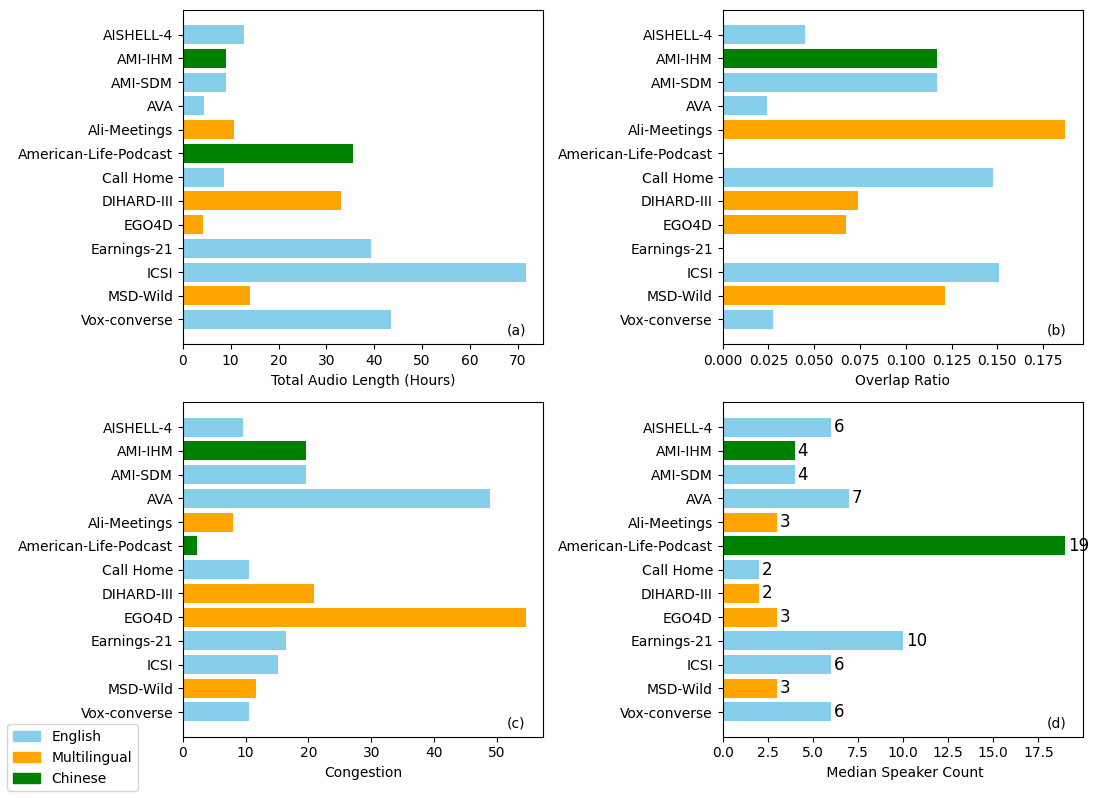

In [36]:
# plt.rcParams.update({
#     "font.size": 14,       # General font size
#     "axes.titlesize": 16,  # Title font size
#     "axes.labelsize": 14,  # Label font size
#     "xtick.labelsize": 12, # X-axis tick labels
#     "ytick.labelsize": 12, # Y-axis tick labels
#     "legend.fontsize": 14  # Legend font size
# })

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(11, 8))

dataset_mapper = {
    "aishell-4-test-None": "AISHELL-4",
    "ali-meetings-test-None": "Ali-Meetings",
    "american-life-test-None": "American-Life-Podcast",
    "ami-test-ihm": "AMI-IHM",
    "ami-test-sdm": "AMI-SDM",
    "ava-avd-test-None": "AVA",
    "callhome-part2-None": "Call Home",
    "dihard-3-full-None": "DIHARD-III",
    "earnings21-test-None": "Earnings-21",
    "ego4d-validation-None": "EGO4D",
    "icsi-meetings-test-None": "ICSI",
    "msdwild-validation-None": "MSD-Wild",
    "voxconverse-test-None": "Vox-converse",
}

language_groups = {
    "English": ["Earnings-21", "ICSI", "American-Life-Podcast","Vox-converse","AMI-IHM", "AMI-SDM"],
    "Multilingual": [ "Dihard-III", "MSD-Wild",  "Call Home", 'AVA','EGO4D'],
    "Chinese": ["Ali-Meetings", "AISHELL-4"],
}
# Dataset names

data = ds_agg_info.copy()
data["dataset"] = data["dataset_id"].apply(lambda x: dataset_mapper.get(x))
data = data.sort_values("dataset", ascending=False)


datasets = data["dataset"].tolist()
# Data values

audio_length= data["Total Duration (h)"]
overlap_percentage = data["% Overlap"]
silence_percentage = data["% Silence"]
speaker_count = data["Median Speakers"]



# Define colors for each language category
colors = {
    "English": "skyblue",
    "Multilingual": "orange",
    "Chinese": "green"
}

# Assign colors to datasets based on language grouping
dataset_colors = []
for dataset in datasets:
    for lang, group in language_groups.items():
        if dataset in group:
            dataset_colors.append(colors[lang])
            break

# Creating subplots

# Plot 1: Audio Length Distribution
axs[0, 0].barh(datasets, audio_length, color=dataset_colors)
axs[0, 0].set_xlabel("Total Audio Length (Hours)")

# Plot 2: Overlap Percentage Comparison
axs[0, 1].barh(datasets, np.asarray(overlap_percentage)/100, color=dataset_colors)
axs[0, 1].set_xlabel("Overlap Ratio")

# Plot 3: Silence Percentage Comparison
axs[1, 0].barh(datasets, silence_percentage, color=dataset_colors)
axs[1, 0].set_xlabel("Congestion")

# Plot 4: Speaker Count Distribution
axs[1, 1].barh(datasets, speaker_count, color=dataset_colors)
axs[1, 1].set_xlabel(" Median Speaker Count")
for container in axs[1, 1].containers:
    axs[1, 1].bar_label(container, padding=2, fontsize=12)

# Add legend for language categories
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[lang]) for lang in colors]
labels = list(colors.keys())
fig.legend(handles, labels, fontsize=10,loc="lower left")
def get_axis_limits(ax, scale=.9):
    return ax.get_xlim()[1]*scale, ax.get_ylim()[0]*scale+0.3
axs[0, 0].annotate('(a)', xy=get_axis_limits(axs[0, 0]))
axs[0, 1].annotate('(b)', xy=get_axis_limits(axs[0, 1]))
axs[1, 0].annotate('(c)', xy=get_axis_limits(axs[1, 0]))
axs[1, 1].annotate('(d)', xy=get_axis_limits(axs[1, 1]))
# Adjust layout
plt.tight_layout()
plt.show()


## Figure 3

In [37]:
df = (
    df_der
    # Merge with the prediction table to get audio_duration and prediction_time
    .merge(
        df_prediction,
        on=["sample_id", "dataset_name", "run_name", 
        "run_id", "experiment_tag", "created_at", 
        "pipeline_name"],
        how="inner", 
        suffixes=["", "_pred"]
    )
    # Compute per sample speed factor
    .assign(
        speed_factor=lambda df: df["audio_duration"] / df["prediction_time"]
    )
    # Deduplicate based on latest created_at for an experiment run
    .pipe(dedup_func)
)

df.head()

,dataset_name,sample_id,pipeline_name,correct,missed detection,total,confusion,false alarm,der,run_name,run_id,experiment_tag,created_at,prediction_time,audio_duration,num_speakers_predicted,num_speakers_reference,speed_factor
33232,voxconverse,0,PyAnnotePipeline,1093.079906,15.347375,1117.39,8.962719,28.413625,0.047185,pyannote-voxconverse-float16,bwzrnx7u,Benchmark-SpeakerDiarization,2025-03-20 03:15:45+00:00,23.068819,1200.064,8,7,52.021042
33233,voxconverse,1,PyAnnotePipeline,1064.236719,22.663469,1110.04,23.139812,42.708469,0.079737,pyannote-voxconverse-float16,bwzrnx7u,Benchmark-SpeakerDiarization,2025-03-20 03:15:45+00:00,22.519042,1200.064,13,12,53.291077
33234,voxconverse,2,PyAnnotePipeline,403.422500,0.675625,413.09,8.991875,6.693125,0.039605,pyannote-voxconverse-float16,bwzrnx7u,Benchmark-SpeakerDiarization,2025-03-20 03:15:45+00:00,8.105422,430.720,1,3,53.139735
33235,voxconverse,3,PyAnnotePipeline,493.377656,22.936531,527.42,11.105812,36.714656,0.134157,pyannote-voxconverse-float16,bwzrnx7u,Benchmark-SpeakerDiarization,2025-03-20 03:15:45+00:00,10.374021,572.224,2,2,55.159324
33236,voxconverse,4,PyAnnotePipeline,1157.346594,50.296656,1256.04,48.396750,11.416656,0.087664,pyannote-voxconverse-float16,bwzrnx7u,Benchmark-SpeakerDiarization,2025-03-20 03:15:45+00:00,21.624620,1200.064,11,9,55.495265


In [38]:
# Get Ablation data
data = (
    df
    .query("experiment_tag == 'Ablation-SpeakerSegmenter' or experiment_tag == 'Ablation-Reference'")
)

# Filter for Pyannote and SpeakerKit
data=data[data['pipeline_name'].isin(['PyAnnotePipeline','SpeakerKitPipeline'])]

# Create Figure 1 Data
df_fig1=(
        data
        .pipe(dedup_func)
        .assign(
            name=lambda df: df["run_name"].str.split("-").str[2]
        )
        .pipe(aggregation_pipeline, groupby_cols=["dataset_name", "name"])
        .sort_values(["dataset_name", "name"])
       )

# Split Dataframe into Pyannote and SpeakerKit
pyannote_ids=[d.split('-')[0] for d in df_fig1['dataset_name'].unique()]
pyannote_df=df_fig1[df_fig1['name'].isin(pyannote_ids)]
speakerkit_df=df_fig1[df_fig1['name'].isin(['stride_1','stride_2','stride_4'])]

######################### SUBPLOT A #########################

# Getting data for Figure 3 - Panel A
df_panela=(speakerkit_df.merge(pyannote_df, on='dataset_name', how='left', sort=False)
    .eval('SpeedUp=speed_factor_x/speed_factor_y')
    .replace(['ami-ihm-val','ami-sdm-val','american-life-podcast-val',
              'dihard-3-core','voxconverse-dev'],
             ['AMI-IHM','AMI-SDM', 'AMLPD', 'DIHARD-III', 'VoxConverse'])
    .replace(['stride_1','stride_2','stride_4'],[1, 2, 4])
    .rename(columns={'name_x':'Stride', 'dataset_name':'Dataset', 'der_x':'DER'})
    )

######################### SUBPLOT B #########################

# Getting data for Figure 3 - Panel B
threshold_speakers = 6
reference = 1
d = (
    data
    .pipe(lambda df: df.loc[df["run_name"].str.contains("^SpeakerKit|pyannote")])
    .pipe(dedup_func)
    .pipe(add_name)
    .pipe(lambda df: df.loc[df["name_ordering"].isin([reference, 4])])
    .assign(
        num_speakers=lambda df: np.where(
            df["num_speakers_reference"] >= threshold_speakers,
            threshold_speakers,
            df["num_speakers_reference"]
        )
    )
    .pipe(aggregation_pipeline, groupby_cols=["name_ordering", "name", "num_speakers"])
    .assign(
        num_speakers=lambda df: 
        df["num_speakers"].astype(str).apply(lambda x: f"{threshold_speakers}+" 
        if x == str(threshold_speakers) else x)
    )
)


<Figure size 1200x800 with 0 Axes>

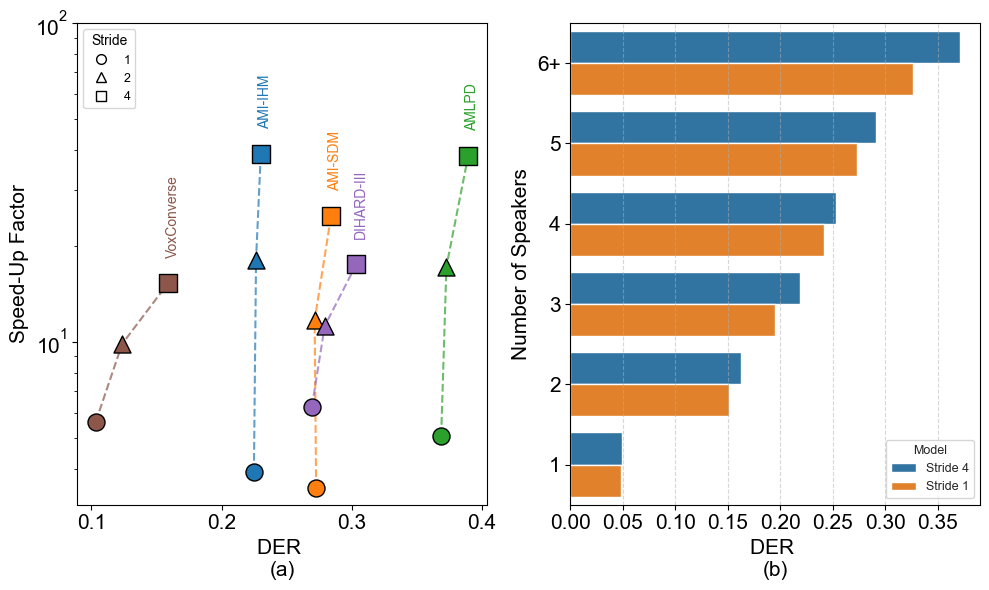

In [39]:
# Configure plotting
plt.figure(figsize=(12, 8))

# Color and marker setup
markers = {1: 'o',2: '^', 4: 's'}  # Different markers for strides
colors=( 
        (0.1725, 0.6274, 0.1725),
        (0.1215, 0.4666, 0.7058),
        (1.0,    0.4980, 0.0549),
        (0.5803, 0.4039, 0.7411),
        (0.5490, 0.3372, 0.2941)
        )
fig,axs=plt.subplots(1, 2, figsize=(11, 5))

# Get datasets
datasets = df_panela['Dataset'].unique()

# Plotting
for idx, dataset in enumerate(datasets):
    subset = df_panela[df_panela['Dataset'] == dataset].sort_values('Stride')
    color = colors[idx]

    # Plot line connecting points
    axs[0].plot(subset['DER'], subset['SpeedUp'], color=color, linestyle='--',
                alpha=0.7, label='_nolegend_')

    # Plot individual points with stride markers
    for _, row in subset.iterrows():
        axs[0].scatter(row['DER'], row['SpeedUp'],
                       marker=markers[row['Stride']],
                       s=150,
                       color=color,
                       edgecolor='black',
                       linewidths=1,
                       zorder=3)
                  
    # Annotate dataset name near the last point of each dataset
    last_point = subset.iloc[-1]
    axs[0].annotate(dataset,
                xy=(last_point['DER'], 
                    last_point['SpeedUp']),
                xytext=(-2, 20),
                textcoords='offset points',
                fontsize=10,
                color=color,
                rotation=90)
   
markers = {1: 'o', 2: '^', 4: 's'}
# Create custom legend for strides only
stride_legend = [plt.Line2D([0], [0], color='white',mec='black',
                 marker=marker, linestyle='None',
                 markersize=7, label=stride ) 
                 for stride, marker in markers.items()]

axs[0].legend(handles=stride_legend, loc='upper left', 
              fontsize=9, title='Stride',title_fontsize=10)

# Axis labels and title
axs[0].set_xlabel('DER \n(a)', fontsize=15)
axs[0].set_ylabel('Speed-Up Factor', fontsize=15)
axs[0].set_yscale('log')
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[0].set_ylim(0,100)
sns.set_style("whitegrid")

data_for_figure_3 = (
    d
    .sort_values(["num_speakers", "name_ordering"], ascending=False)
    .assign(name=lambda df: np.where(df["name"] == "1", 
                                     "Stride 1", "Stride 4"))
)

# Add thicker border for the barplots
ax = sns.barplot(
                data=data_for_figure_3,
                x="der",
                y="num_speakers",
                hue="name",
                ax=axs[1],
                )

# Configure Plot Axes
ax.set_xlabel("DER \n(b)", size=15)
ax.set_ylabel("Number of Speakers", size=15)
ax.legend(title="Model", fontsize=9, 
          title_fontsize=9)
ax.set_xticklabels([f"{tick:.2f}" 
                    for tick in ax.get_xticks()], fontsize=15)
ax.set_yticklabels(data_for_figure_3["num_speakers"].unique(), 
                   fontsize=15)
ax.figure.set_size_inches(10, 6)
ax.grid(axis="x", linestyle="--", alpha=0.50)

# Adjust layout and show
plt.tight_layout()
plt.show()

## Figure 4

In [40]:
# Filter for Ablation data
data = df.query("experiment_tag == 'Ablation-Stagewise'").copy()

# Prepare Data for Figure 4
d = (
    data
    .pipe(dedup_func)
    .assign(
        name=lambda df: df["run_name"].str.split("-").str[1]
    )
    .query("name != 'super_oracle'")
    .pipe(aggregation_pipeline, groupby_cols=["dataset_name", "name"])
    .sort_values(["dataset_name", "name"])
    .assign(
        dataset_name=lambda df: 
        np.select(
            [
                df["dataset_name"].str.contains("ami-ihm"),
                df["dataset_name"].str.contains("ami-sdm"),
                df["dataset_name"].str.contains("voxconverse"),
                df["dataset_name"].str.contains("american-life-podcast"),
            ],
            [
                "AMI-IHM",
                "AMI-SDM",
                "VoxConverse",
                "American-Life-Podcast",
            ],
            default="DIHARD-III"
        )
    )
)

In [41]:
def plot_der_breakdown(d, figsize=(15, 6)):
    """
    Create a stacked bar plot showing DER breakdown components.
    
    Parameters:
    -----------
    d : pandas.DataFrame
        DataFrame containing columns: dataset_name, name, missed_detection_rate,
        false_alarm_rate, confusion_rate, der
    figsize : tuple
        Figure size in inches (width, height)
    """
    # Sort the data
    d = d.sort_values(["dataset_name", "name"])
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Prepare data
    datasets = d["dataset_name"].unique()
    models_per_dataset = d.groupby("dataset_name")["name"].nunique()
    
    # Calculate positions for bars
    all_positions = []
    current_pos = 0
    for dataset in datasets:
        n_models = models_per_dataset[dataset]
        positions = np.arange(current_pos, current_pos + n_models)
        all_positions.extend(positions)
        current_pos += n_models + 1  # Add space between dataset groups
    
    # Plot stacked bars
    bottom = np.zeros(len(d))
    components = ['missed_detection_rate', 'false_alarm_rate', 'confusion_rate']
    labels = ['Missed Detection Rate', 'False Alarm Rate', 'Confusion Rate']
    
    bars = []
    for component, label, _ in zip(components, labels, colors):
        values = d[component].values
        b = ax.bar(all_positions, values, bottom=bottom, label=label)
        bars.append(b)
        
        # Add percentage labels inside bars
        for i, (height, total) in enumerate(zip(values, bottom + values)):
            if height > 0.01:  # Only show label if bar segment is large enough
                ax.text(all_positions[i], bottom[i] + height/2,
                       f'{height:.01}',
                       ha='center', va='center',
                       color='black', fontsize=10)
        bottom += values
    # Customize axis
    ax.set_ylabel('Rate',fontsize=15)

    # Set x-axis ticks and labels
    dataset_positions = []
    dataset_centers = []
    current_pos = 0
    for dataset in datasets:
        n_models = models_per_dataset[dataset]
        positions = np.arange(current_pos, current_pos + n_models)
        dataset_positions.extend(positions)
        dataset_centers.append(positions.mean())
        current_pos += n_models + 1
    
    # Set tick positions and labels for models
    ax.set_xticks(all_positions)
    ax.set_xticklabels(d['name'], rotation=45, ha='right',fontsize=12)
    ax.tick_params( labelsize=12)
    
    # Add dataset labels
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(dataset_centers)
    ax2.set_xticklabels(datasets,fontsize=14)
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Adjust layout
    plt.tight_layout()
    ax.grid(False)
    ax2.grid(False)
    return fig, ax

(<Figure size 1000x800 with 2 Axes>, <Axes: ylabel='Rate'>)

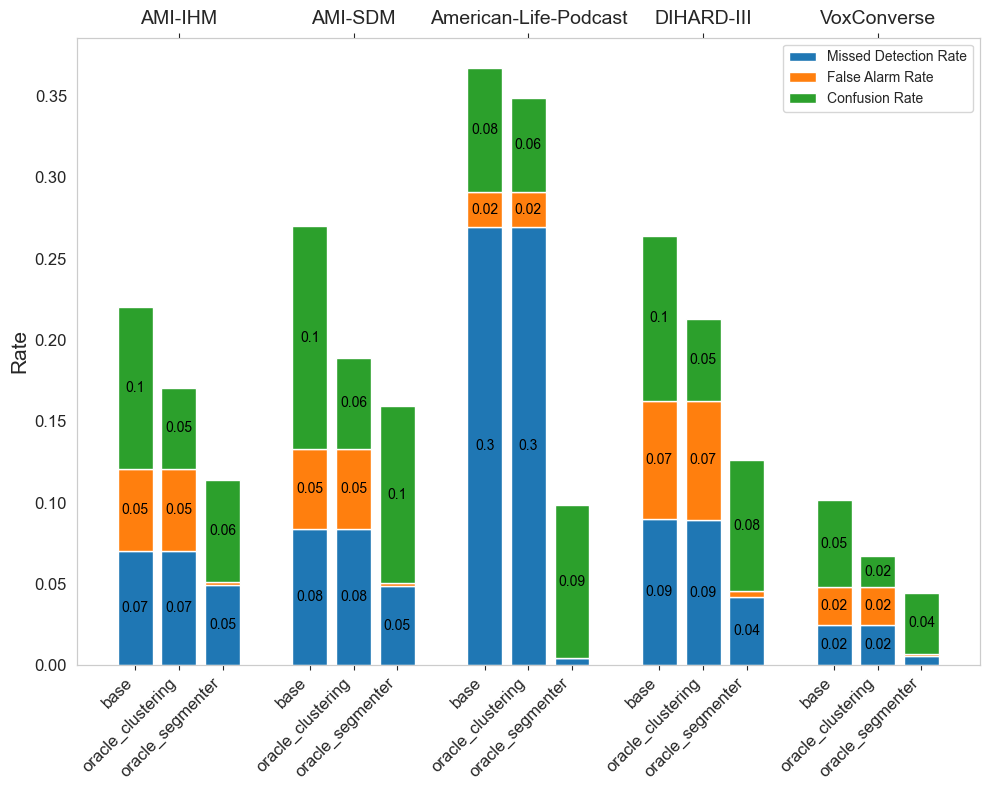

In [42]:
# Plot Figure 4
plot_der_breakdown(d,figsize=(10, 8))